In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

## Understanding the Task

In this competition, we aim to predict the **Severity Impairment Index (SII)**, a measure derived from the **Parent-Child Internet Addiction Test (PCIAT)**. The SII reflects the degree of problematic internet use in participants aged 5-22, based on various clinical and behavioral data. 

The dataset comes from the **Healthy Brain Network (HBN)** study, which includes comprehensive clinical and research screenings. Our task is to leverage two primary data sources:
- **Actigraphy Data**: Time-series data captured by a wrist-worn accelerometer over a period of up to 30 days.
- **Tabular Data**: Demographic, physical, behavioral, and mental health measurements gathered from various clinical instruments, including:
  - **Demographics** (age, sex)
  - **Physical Activity Questionnaires**
  - **Fitness and Physical Measures**
  - **Sleep Disturbance Scales**
  - **Internet Usage Behavior** (daily hours of use)

The target variable, **SII**, ranges from:
- `0` for None
- `1` for Mild
- `2` for Moderate
- `3` for Severe

The primary challenge is that the majority of participants have missing values in many fields, and a portion of the training data lacks SII labels. The test data contains complete SII values, which are withheld during the competition.

### Data Files
- **series_train.parquet / series_test.parquet**: Continuous accelerometer readings (actigraphy) for each participant. Each file contains:
  - **X, Y, Z**: Raw accelerometer readings.
  - **ENMO**: Calculated metric of movement intensity.
  - **AngleZ**: Arm position relative to the horizontal plane.
  - **non-wear_flag**: Whether the accelerometer was not worn (0 = worn, 1 = not worn).
  - **Light**: Ambient light level in lux.
  - **Time of Day**: Time of recording, broken down into seconds.
  
- **train.csv / test.csv**: Tabular data including demographics, internet usage, and clinical measures.
- **data_dictionary.csv**: Descriptions of all fields and clinical instruments used in the study.

### Goal
Using the combination of actigraphy data and tabular clinical measures, your goal is to predict each participant's **Severity Impairment Index (SII)**, identifying patterns that link physical activity, fitness, and internet usage behaviors with internet addiction severity.



# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")

# Importing Data

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.00000,10.000000,13.000000,22.000000
Basic_Demos-Sex,3960.0,0.372727,0.483591,0.0,0.00000,0.000000,1.000000,1.000000
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.00000,65.000000,75.000000,999.000000
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000
...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,2736.0,27.896199,20.338853,0.0,12.00000,26.000000,41.000000,93.000000
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.00000,39.000000,46.000000,96.000000
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.00000,55.000000,64.000000,100.000000
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.00000,1.000000,2.000000,3.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [6]:
train["sii"].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [7]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())

categorical_cols = train.select_dtypes(include=['object', 'category']).columns
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])


In [8]:
target_column = 'sii'
train_data_cleaned = train.dropna(subset=[target_column])

train_data_cleaned.head()
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             3960 non-null   object 
 5   CGAS-CGAS_Score                         3960 non-null   float64
 6   Physical-Season                         3960 non-null   object 
 7   Physical-BMI                            3960 non-null   float64
 8   Physical-Height                         3960 non-null   float64
 9   Physical-Weight                         3960 non-null   float64
 10  Physical-Waist_Circumference            3960 non-null   floa

# EDA (Exploratory Data Analysis)

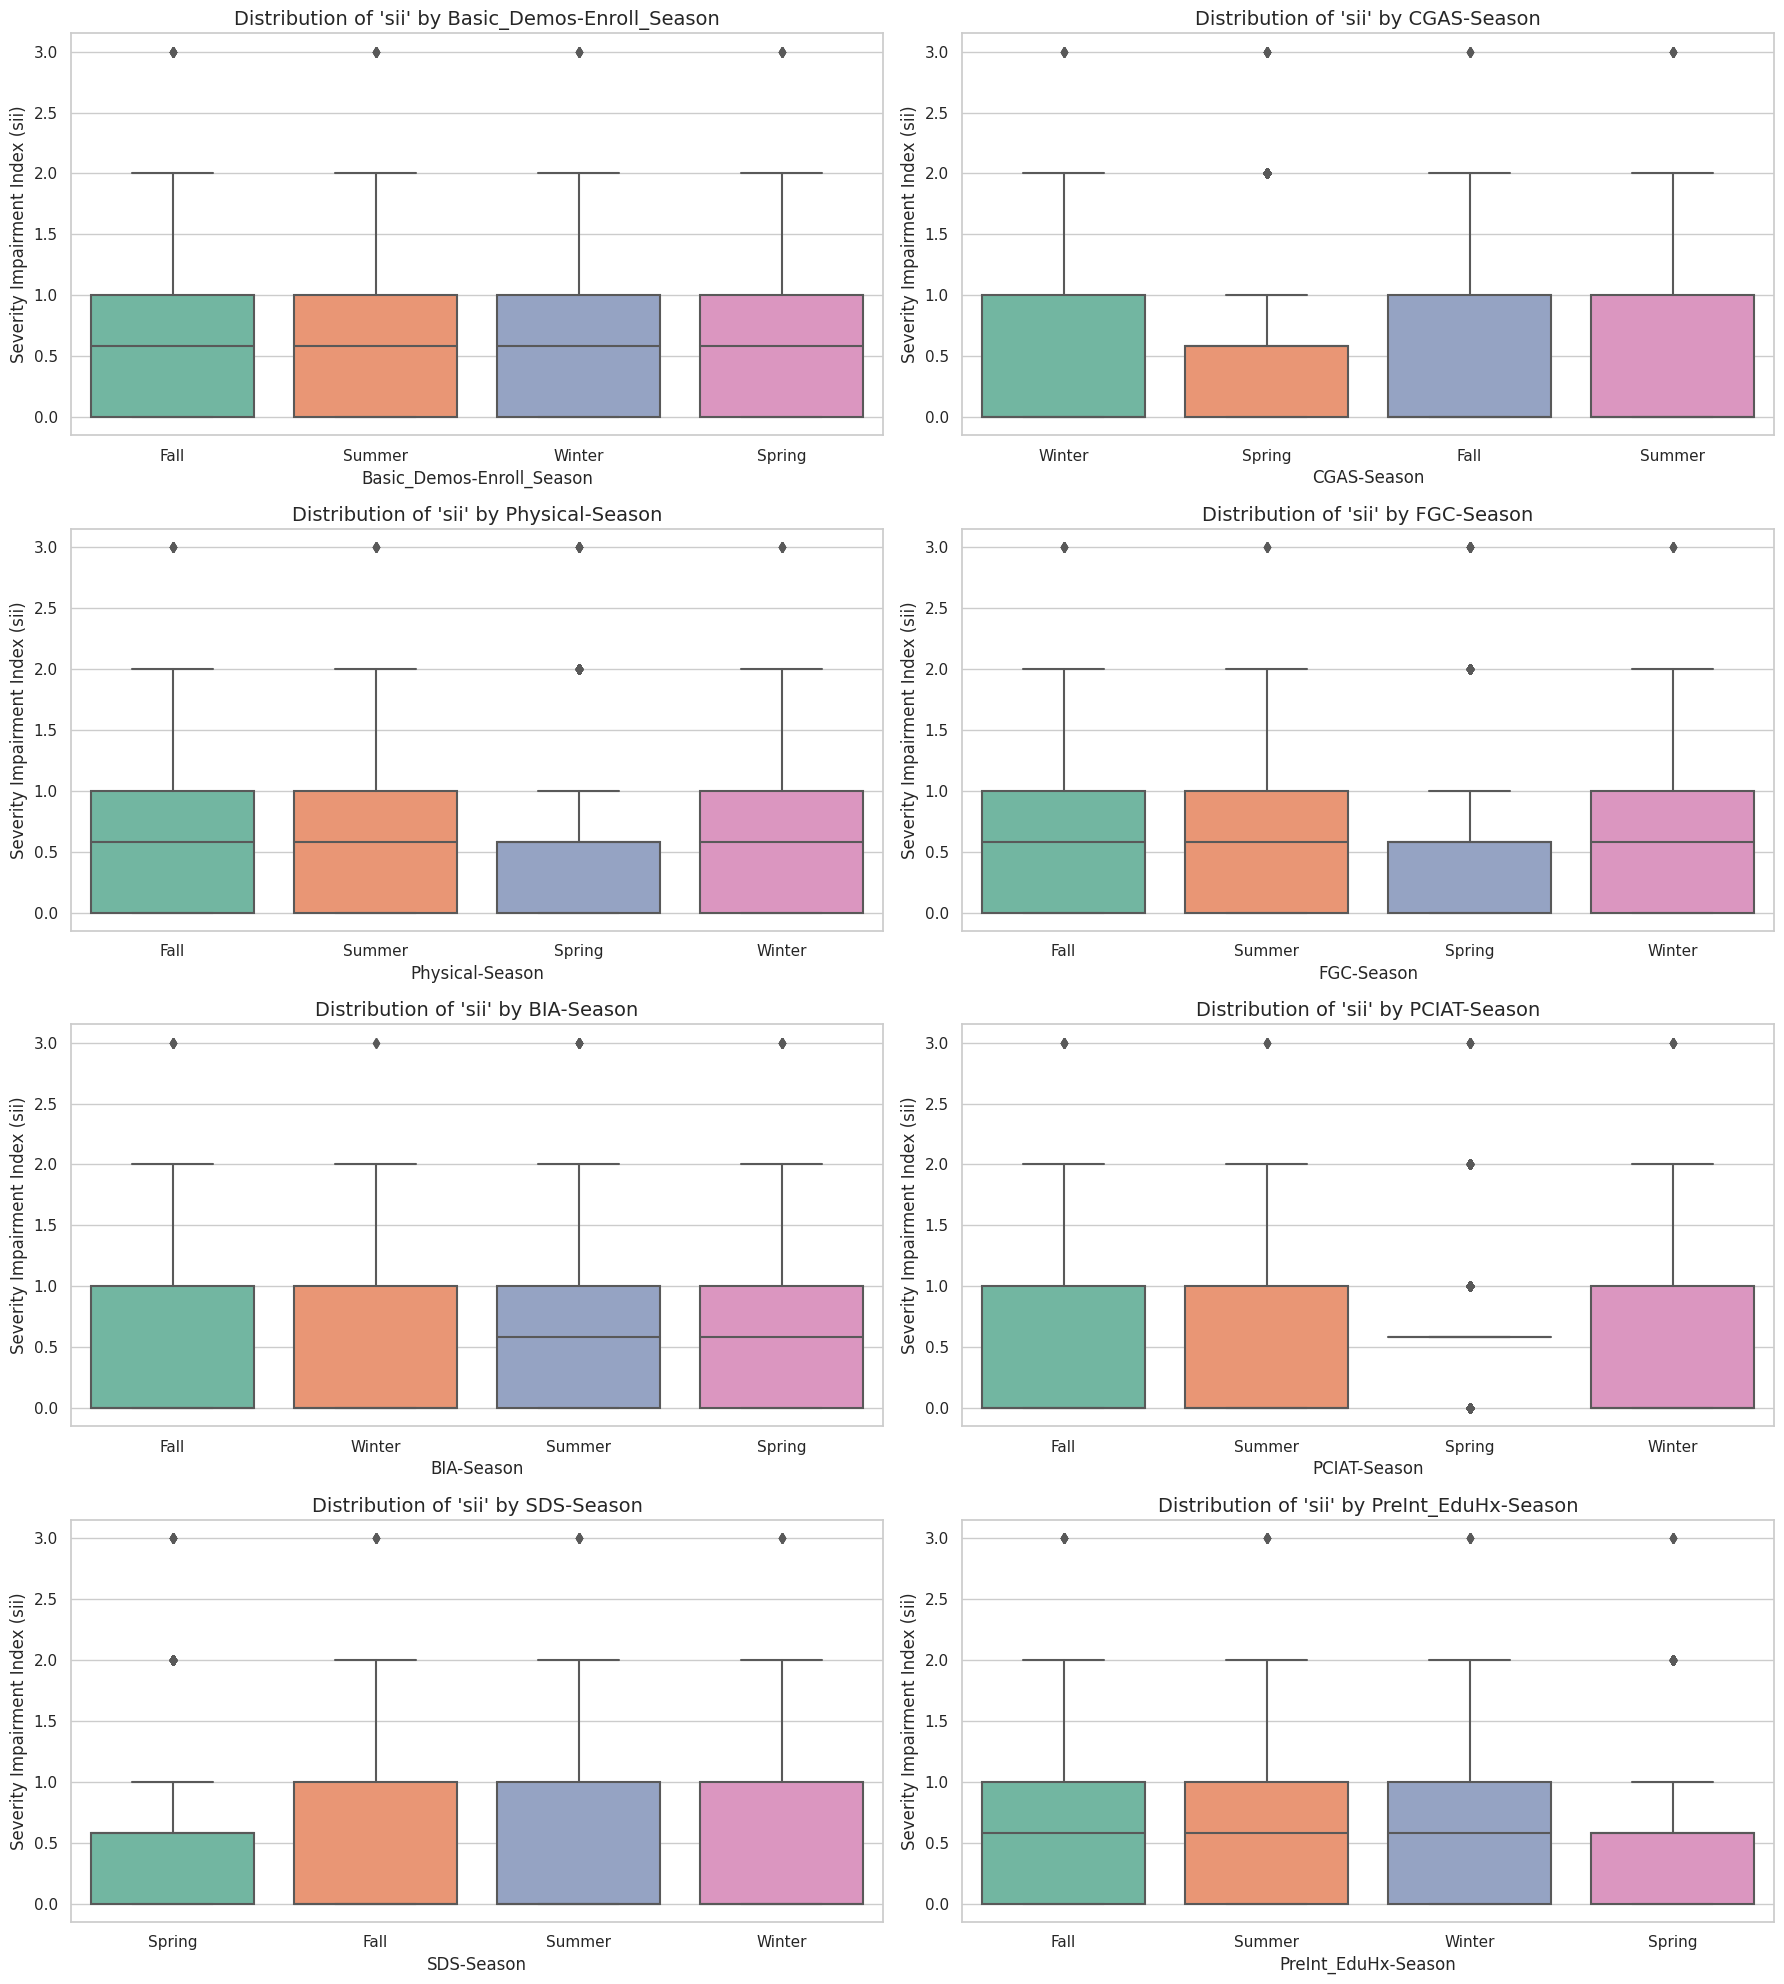

In [9]:
categorical_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
                       'FGC-Season', 'BIA-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']

plt.figure(figsize=(18, 20))
sns.set(style="whitegrid")

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 2, i)  # Create subplots: 4 rows, 2 columns, plot index i
    sns.boxplot(x=col, y='sii', data=train_data_cleaned, palette="Set2")
    

    plt.xlabel(f'{col}', fontsize=12)
    plt.ylabel('Severity Impairment Index (sii)', fontsize=12)
    plt.title(f"Distribution of 'sii' by {col}", fontsize=14)
    
    plt.xticks(rotation=30 if train_data_cleaned[col].nunique() > 5 else 0)
    
plt.tight_layout()
plt.show()

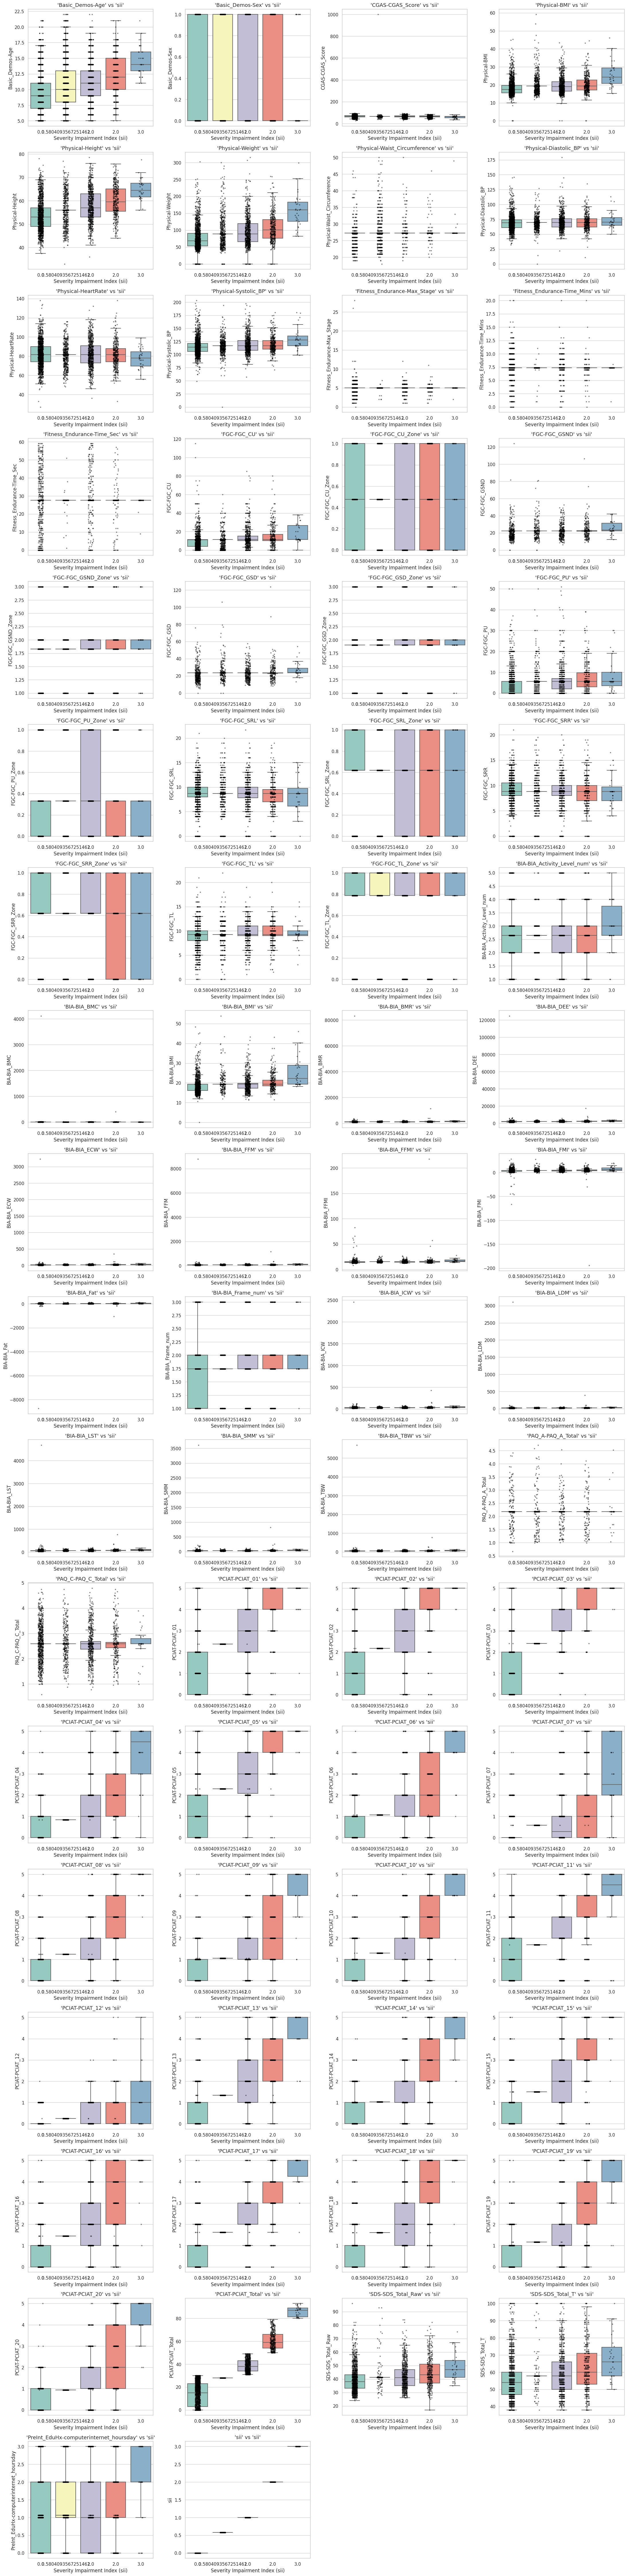

In [10]:
numerical_cols = train_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
plots_per_row = 4  
n_rows = (len(numerical_cols) + plots_per_row - 1) // plots_per_row

plt.figure(figsize=(22, 5 * n_rows))
sns.set(style="whitegrid")

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, plots_per_row, i + 1)
    sns.boxplot(x='sii', y=col, data=train_data_cleaned, palette="Set3", showfliers=False)
    sns.stripplot(x='sii', y=col, data=train_data_cleaned, color='black', size=3, alpha=0.5, jitter=True)
    
    plt.title(f"'{col}' vs 'sii'", fontsize=13)
    plt.xlabel('Severity Impairment Index (sii)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    plt.tight_layout(pad=1.0)

plt.show()


# Encoding  

In [11]:
season_cols = [
    'Basic_Demos-Enroll_Season', 
    'CGAS-Season', 
    'Physical-Season', 
    'FGC-Season', 
    'BIA-Season', 
    'PCIAT-Season', 
    'SDS-Season', 
    'PreInt_EduHx-Season',
    'Fitness_Endurance-Season',
    'PAQ_A-Season', 
    'PAQ_C-Season'
]
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}
for col in season_cols:
    if col in train_data_cleaned.columns:
        train_data_cleaned[col] = train_data_cleaned[col].replace(season_mapping)
for col in season_cols:
    print(f"Unique values in {col}:", train_data_cleaned[col].unique())

Unique values in Basic_Demos-Enroll_Season: [2 1 3 0]
Unique values in CGAS-Season: [3 0 2 1]
Unique values in Physical-Season: [2 1 0 3]
Unique values in FGC-Season: [2 1 0 3]
Unique values in BIA-Season: [2 3 1 0]
Unique values in PCIAT-Season: [2 1 0 3]
Unique values in SDS-Season: [0 2 1 3]
Unique values in PreInt_EduHx-Season: [2 1 3 0]
Unique values in Fitness_Endurance-Season: [0 2 1 3]
Unique values in PAQ_A-Season: [3 1 2 0]
Unique values in PAQ_C-Season: [0 2 1 3]


# Training Model

In [12]:
common_columns = train_data_cleaned.columns.intersection(test.columns)
X = train_data_cleaned[common_columns].drop(columns=['id'])
y = train_data_cleaned['sii']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3168, 58)
X_test shape: (792, 58)
y_train shape: (3168,)
y_test shape: (792,)


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  #standardizes the features
    ('pca', PCA(n_components=0.95))  #95% variance retained
])

X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

pca = pca_pipeline.named_steps['pca']
explained_variance_ratio = pca.explained_variance_ratio_.sum()
n_components = pca.n_components_

print(f"Number of components selected: {n_components}")
print(f"Explained variance ratio: {explained_variance_ratio:.2f}")

Number of components selected: 32
Explained variance ratio: 0.95
